In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime


<class 'numpy.float64'>


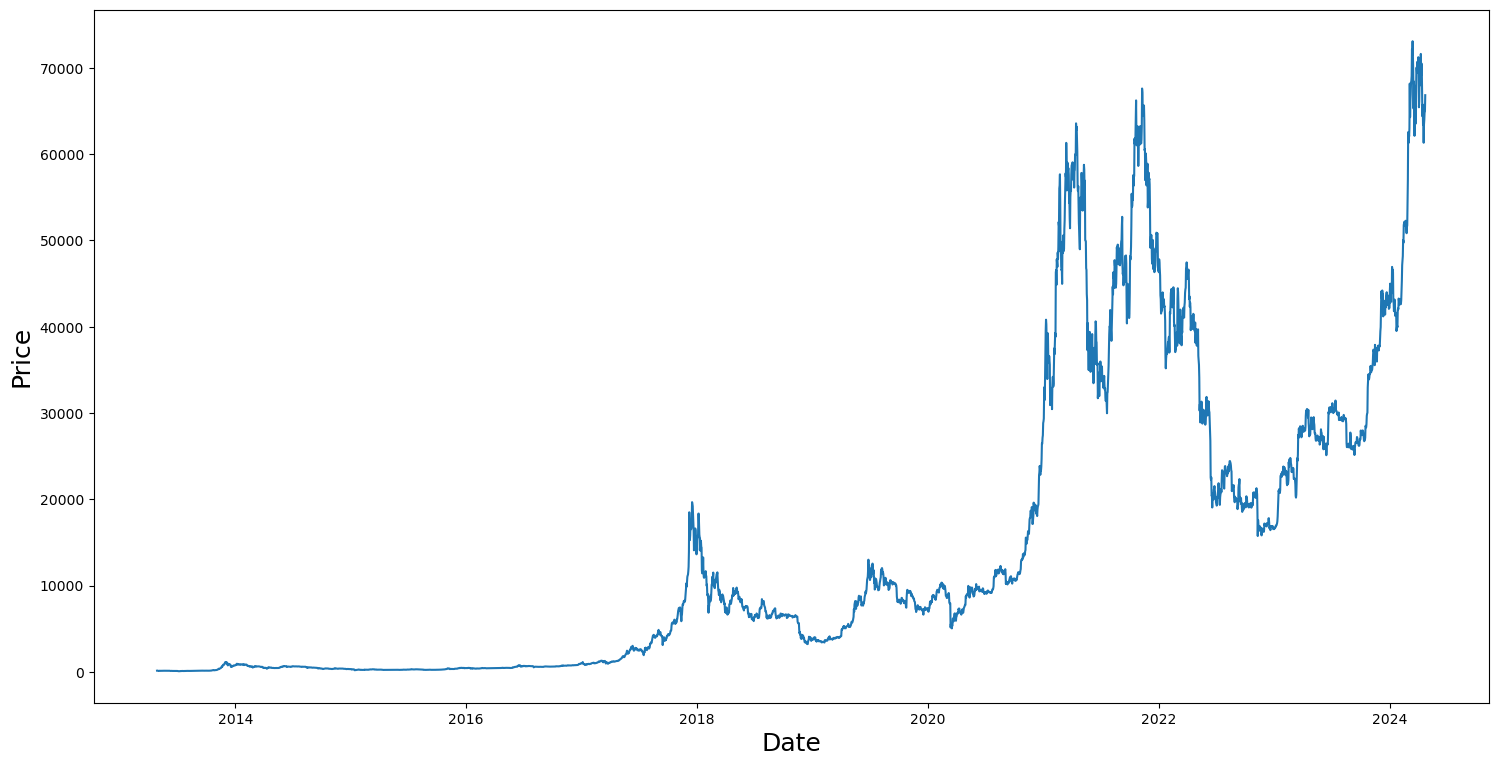

In [21]:
# Load data
full_df = pd.read_csv('btc-usd-max.csv')
df = pd.read_csv('btc-usd-max.csv', usecols=[1], engine='python')

# Preprocess data
full_df['snapped_at'] = pd.to_datetime(full_df['snapped_at'])
full_df['SMA_30'] = full_df['price'].rolling(window=30).mean()
full_df['EMA_30'] = full_df['price'].ewm(span=30, adjust=False).mean()
full_df['SMA_30'] = full_df['SMA_30'].fillna(method='bfill')

# Visualization
plt.figure(figsize = (18,9))
plt.plot(full_df.iloc[:,0], full_df['price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [3]:
price_scaler = MinMaxScaler(feature_range=(0, 1))
SMA_scaler = MinMaxScaler(feature_range=(0,1))
EMA_scaler = MinMaxScaler(feature_range=(0,1))

price_scaler.fit(full_df[['price']])
SMA_scaler.fit(full_df[['SMA_30']])
EMA_scaler.fit(full_df[['EMA_30']])

full_df['price'] = price_scaler.transform(full_df[['price']])
full_df['SMA_30'] = SMA_scaler.transform(full_df[['SMA_30']])
full_df['EMA_30'] = EMA_scaler.transform(full_df[['EMA_30']])


In [4]:
# Convert sequence for LSTM model
def create_sequences(df, seq_length):
    xs, ys = [], []
    data = df[['price', 'SMA_30', 'EMA_30']].values
    for i in range(len(data)-seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(full_df, seq_length)
print(X.shape)

(3982, 30, 3)


In [5]:
# split into testing and training
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [6]:
# Build model
model = Sequential([
    LSTM(50, activation='tanh', return_sequences = True, input_shape=(seq_length, 3)),
    LSTM(50, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Fit model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
94/94 [==============================] - 4s 17ms/step - loss: 0.0015
Epoch 2/20
94/94 [==============================] - 2s 17ms/step - loss: 4.9704e-04
Epoch 3/20
94/94 [==============================] - 2s 17ms/step - loss: 4.5526e-04
Epoch 4/20
94/94 [==============================] - 2s 18ms/step - loss: 3.4233e-04
Epoch 5/20
94/94 [==============================] - 2s 18ms/step - loss: 2.7864e-04
Epoch 6/20
94/94 [==============================] - 2s 17ms/step - loss: 2.4241e-04
Epoch 7/20
94/94 [==============================] - 2s 17ms/step - loss: 1.8960e-04
Epoch 8/20
94/94 [==============================] - 2s 17ms/step - loss: 1.5472e-04
Epoch 9/20
94/94 [==============================] - 2s 17ms/step - loss: 1.9494e-04
Epoch 10/20
94/94 [==============================] - 2s 17ms/step - loss: 1.6383e-04
Epoch 11/20
94/94 [==============================] - 2s 17ms/step - loss: 1.7232e-04
Epoch 12/20
94/94 [==============================] - 2s 17ms/step - loss: 1.35

In [7]:
# Predict
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
allPredict = model.predict(X)


# Rescale 
trainPredict = price_scaler.inverse_transform(trainPredict)
testPredict = price_scaler.inverse_transform(testPredict)
rescaled_X_train = price_scaler.inverse_transform(X_train.reshape(-1, 1))
rescaled_y_train = price_scaler.inverse_transform(y_train.reshape(-1, 1))
rescaled_X_test = price_scaler.inverse_transform(X_test.reshape(-1, 1))
rescaled_y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))
allPredict = price_scaler.inverse_transform(allPredict)

125/125 [==============================] - 1s 6ms/step


In [8]:
mae = mean_absolute_error(rescaled_y_test, testPredict)
print(mae)

1146.0114320441332


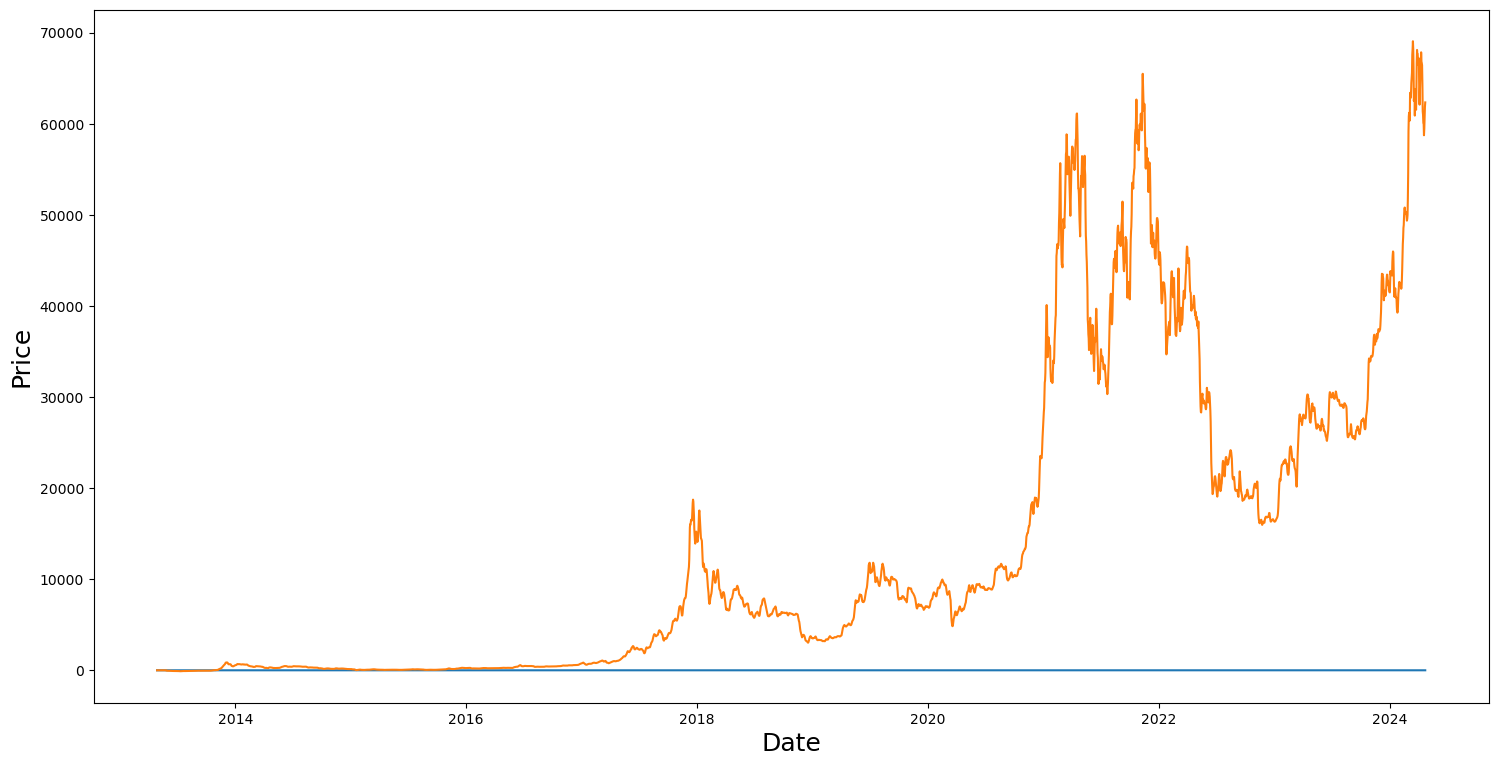

In [9]:
# Visualization
zeros = np.zeros(30)
beginning_and_pred = np.concatenate((zeros,allPredict.flatten())) # Add zeros to the first 30 days, because there are no predictions for these days
plt.figure(figsize = (18,9))
plt.plot(full_df.iloc[:,0], full_df['price'])
plt.plot(full_df.iloc[:,0], beginning_and_pred)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [2]:
# get yfinance data
import yfinance as yf

BTC_data = yf.download("BTC-USD", period="max", interval="1d")
BTC_data.index = pd.to_datetime(BTC_data.index)

[*********************100%%**********************]  1 of 1 completed


In [3]:
def model(df, win_size, n_units=50, n_epochs=150, batch_size=32):
    """Input: yfinance dataframe, , window size, hyperparameters (units, epochs, batch size)
    Output: performance metrics """

    #print("Entering function correctly")
    
    df_copy = df.copy()

    #print("df_copy:", df_copy)

    # Calculate and add EMA and SMA to dataframe 
    df_copy['SMA'] = df_copy['Close'].rolling(window=win_size).mean()
    df_copy['EMA'] = df_copy['Close'].ewm(span=win_size, adjust=False).mean()
    df_copy['SMA'] = df_copy['SMA'].fillna(method='bfill') # Fill the NaN's

    # Rescale, different scalers for each feature
    price_scaler = MinMaxScaler(feature_range=(0, 1))
    SMA_scaler = MinMaxScaler(feature_range=(0,1))
    EMA_scaler = MinMaxScaler(feature_range=(0,1))

    price_scaler.fit(df_copy[['Close']])
    SMA_scaler.fit(df_copy[['SMA']])
    EMA_scaler.fit(df_copy[['EMA']])

    df_copy['Close'] = price_scaler.transform(df_copy[['Close']])
    df_copy['SMA'] = SMA_scaler.transform(df_copy[['SMA']])
    df_copy['EMA'] = EMA_scaler.transform(df_copy[['EMA']])

    # create sequences, each element in sequence has 3 features, each sequence has win_size elements
    def create_sequences(df, seq_length):
        xs, ys = [], []
        data = df[['Close', 'SMA', 'EMA']].values
        for i in range(len(data)-seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length, 0]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    # X[i] is sequence starting from day i, y[i] is price prediction for day i + win_size
    X, y = create_sequences(df_copy, win_size)

    # split into training and testing
    train_size = int(len(X) * 0.85)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create model
    model = Sequential([
        LSTM(units=n_units, activation='tanh', return_sequences = True, input_shape=(win_size, 3)),
        LSTM(units=n_units, activation='tanh'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Fit model
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

    # Predict
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    allPredict = model.predict(X)
    

    # Rescale everything back to original scale
    trainPredict = price_scaler.inverse_transform(trainPredict)
    testPredict = price_scaler.inverse_transform(testPredict)
    rescaled_X_train = price_scaler.inverse_transform(X_train.reshape(-1, 1))
    rescaled_y_train = price_scaler.inverse_transform(y_train.reshape(-1, 1))
    rescaled_X_test = price_scaler.inverse_transform(X_test.reshape(-1, 1))
    rescaled_y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))
    rescaled_allPredict = price_scaler.inverse_transform(allPredict)

    # Add back first 30 days
    zeros = np.zeros(30)
    beginning_and_pred = np.concatenate((zeros,rescaled_allPredict.flatten()))

    # Calculate evaluation metrics
    mse = mean_squared_error(rescaled_y_test, testPredict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(rescaled_y_test, testPredict)
    r2 = r2_score(rescaled_y_test, testPredict)

    return beginning_and_pred, mse, rmse, mae, r2

predictions, mse, rmse, mae, r2 = model(BTC_data, win_size=30, n_units=50, n_epochs=20, batch_size=50)
    

Epoch 1/20
60/60 [==============================] - 3s 21ms/step - loss: 0.0059
Epoch 2/20
60/60 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 3/20
60/60 [==============================] - 1s 21ms/step - loss: 7.4017e-04
Epoch 4/20
60/60 [==============================] - 1s 21ms/step - loss: 6.6404e-04
Epoch 5/20
60/60 [==============================] - 1s 20ms/step - loss: 6.2349e-04
Epoch 6/20
60/60 [==============================] - 1s 21ms/step - loss: 5.2678e-04
Epoch 7/20
60/60 [==============================] - 1s 21ms/step - loss: 4.7801e-04
Epoch 8/20
60/60 [==============================] - 1s 21ms/step - loss: 4.1723e-04
Epoch 9/20
60/60 [==============================] - 1s 21ms/step - loss: 4.5003e-04
Epoch 10/20
60/60 [==============================] - 1s 21ms/step - loss: 3.6039e-04
Epoch 11/20
60/60 [==============================] - 1s 21ms/step - loss: 3.5551e-04
Epoch 12/20
60/60 [==============================] - 1s 21ms/step - loss: 3.3085e-

In [4]:
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

MSE: 1962802.5942862458
RMSE: 1401.000568981414
MAE: 884.4209712595602
R2: 0.9906588371103396


In [5]:
plt.figure(figsize = (18,9))
plt.plot(BTC_data.index, BTC_data['Close'])
plt.plot(BTC_data.index, predictions)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

[*********************100%%**********************]  1 of 1 completed


                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2014-09-17  465.864014  468.174011  ...  457.334015  21056800
2014-09-18  456.859985  456.859985  ...  424.440002  34483200
2014-09-19  424.102997  427.834991  ...  394.795990  37919700

[3 rows x 6 columns]
                    Open          High  ...     Adj Close       Volume
Date                                    ...                           
2024-04-28  63423.515625  64321.484375  ...  63113.230469  17334827993
2024-04-29  63106.363281  64174.878906  ...  63841.121094  26635912073
2024-04-30  63838.980469  64613.570312  ...  59572.875000  35721416704

[3 rows x 6 columns]


TypeError: only integer scalar arrays can be converted to a scalar index